In [1]:
!pip install lightgbm==3.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.7 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.1.0
    Uninstalling lightgbm-4.1.0:
      Successfully uninstalled lightgbm-4.1.0


In [2]:
#@title Load coordinates nearest points
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.pipeline import Pipeline
import pickle
from scipy.stats import chi2_contingency

pd.options.display.max_rows = 999


coor=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/distan_lat43.302lon-8.377p4R4Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="Nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

In [3]:
#@title Load station (present weather). Load meteorological model forecast D0. Display relation BRFG with model variables.
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/LECOY2018Y2022.csv",
                          usecols =["time","wxcodes_o"],
                          parse_dates=["time"]).dropna().set_index("time")

print("Weather frequencies")
display(station["wxcodes_o"].value_counts(normalize=True).map(lambda n: '{:.2%}'.format(n)))

#label br/fg if weather code contains FG or BR
station["wx_l"] = "WM"
mask = station['wxcodes_o'].str.contains("BR")
station.loc[mask,["wx_l"]] = "BR"
mask = station['wxcodes_o'].str.contains("FG")
station.loc[mask,["wx_l"]] = "FG"
mask = station['wxcodes_o'].str.contains("DZ")
station.loc[mask,["wx_l"]] = "DZ"
mask = station['wxcodes_o'].str.contains("RA")
station.loc[mask,["wx_l"]] = "RA"

station["wx_l"]=pd.Categorical(station["wx_l"])

#display(station.sample(50).head(20))
print("*****************************")
print("Climatology")
display(station["wx_l"].value_counts(normalize=True).transform(lambda x: '{:,.0%}'.format(x)))

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/lat43.302lon-8.377p4R4KmD0Y2022.csv",parse_dates=["time"])
model = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).drop(columns=["wxcodes_o",]).dropna()
#display(df_all)

display(station.sample(30))


Weather frequencies


wxcodes_o
M                  83.07%
-RA                 4.35%
BCFG                2.48%
FG                  1.87%
BR                  1.35%
RA                  1.30%
-DZ                 0.75%
-RA BR              0.57%
VCFG                0.55%
SHRA                0.48%
-SHRA               0.33%
BR BCFG             0.33%
PRFG                0.28%
RA BR               0.24%
DZ                  0.19%
-DZ BR              0.13%
-RA BCFG            0.13%
VCSH                0.12%
-RADZ               0.11%
+RA                 0.09%
FZFG                0.08%
+SHRA               0.07%
-DZ BCFG            0.06%
VCTS                0.06%
BCFG MIFG           0.05%
MIFG                0.05%
BR -DZ              0.04%
RA BCFG             0.04%
BCFG -DZ            0.04%
-RA BR BCFG         0.04%
RADZ                0.03%
PRFG BCFG           0.03%
-RA FG              0.03%
DZ BR               0.03%
SHGR                0.03%
BR -RA              0.03%
BCFG BR             0.02%
BR DZ               0.02%
+R

*****************************
Climatology


wx_l
WM    83%
RA     8%
FG     6%
BR     1%
DZ     1%
Name: proportion, dtype: object

,wxcodes_o,wx_l
time,,
2021-11-02 20:30:00,M,WM
2019-06-02 20:30:00,M,WM
2022-04-22 11:00:00,M,WM
2022-09-29 00:00:00,M,WM
2018-04-18 05:30:00,M,WM
2020-06-14 20:00:00,M,WM
2022-11-27 12:48:00,-RA,RA
2022-03-21 13:00:00,M,WM
2020-06-24 06:30:00,M,WM


Round 0


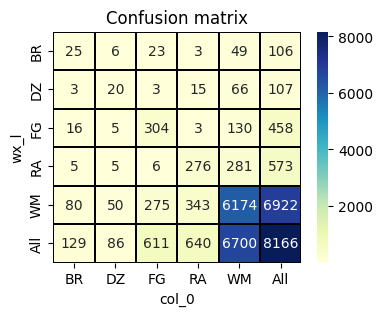

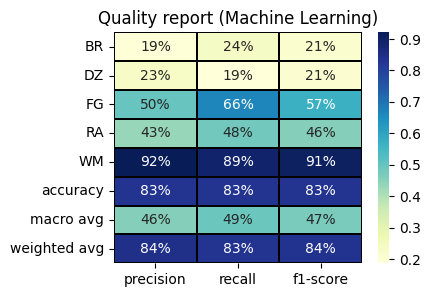

,feature,feature_per
102,dayofyear,3.0%
100,hour,2.6%
33,visibility1,1.9%
83,visibility3,1.8%
8,visibility0,1.7%
58,visibility2,1.7%
50,dir2,1.6%
41,cin1,1.6%
75,dir3,1.6%
0,dir0,1.5%


Round 1


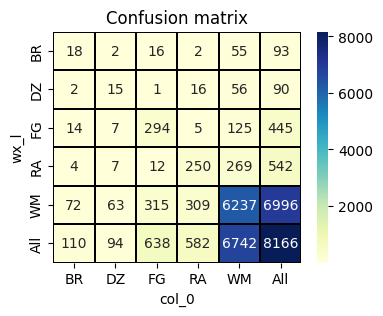

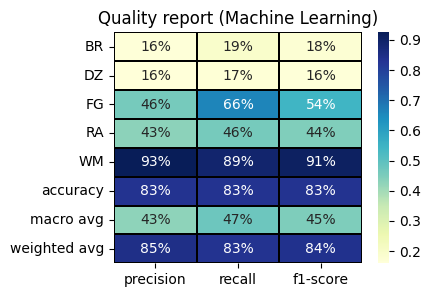

,feature,feature_per
100,hour,2.9%
102,dayofyear,2.7%
33,visibility1,1.9%
58,visibility2,1.8%
8,visibility0,1.8%
83,visibility3,1.8%
75,dir3,1.6%
16,cin0,1.5%
0,dir0,1.5%
50,dir2,1.5%


Round 2


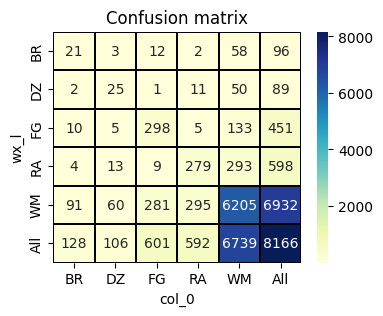

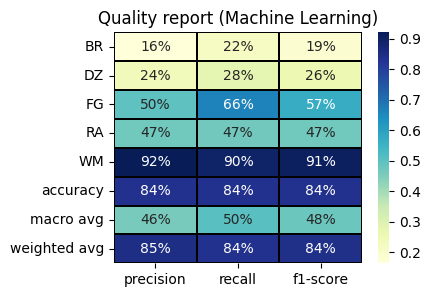

,feature,feature_per
100,hour,2.6%
102,dayofyear,2.5%
58,visibility2,1.9%
33,visibility1,1.8%
83,visibility3,1.7%
8,visibility0,1.7%
50,dir2,1.6%
75,dir3,1.5%
16,cin0,1.5%
41,cin1,1.5%


Round 3


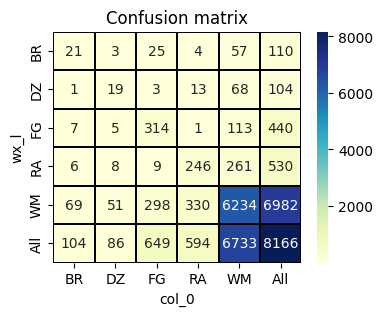

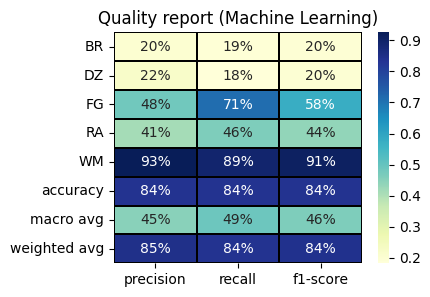

,feature,feature_per
102,dayofyear,2.9%
100,hour,2.9%
58,visibility2,1.9%
33,visibility1,1.8%
83,visibility3,1.8%
16,cin0,1.7%
8,visibility0,1.7%
75,dir3,1.6%
66,cin2,1.6%
91,cin3,1.4%


Round 4


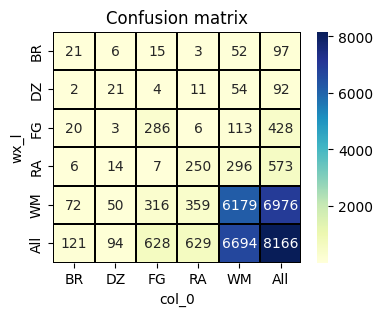

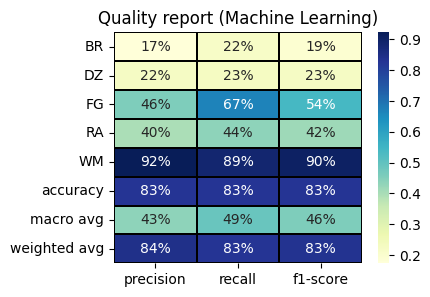

,feature,feature_per
100,hour,2.7%
102,dayofyear,2.6%
58,visibility2,2.0%
8,visibility0,1.8%
33,visibility1,1.8%
83,visibility3,1.7%
75,dir3,1.6%
0,dir0,1.6%
16,cin0,1.4%
50,dir2,1.4%


Execution time: 8.19 minutes


In [4]:
#@title ML LGBMClassifier. Samples 10. Heidke Skill score.

from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro
from sklearn.metrics import accuracy_score

start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.wx_l
X = df_all.iloc[:,1:]


# loop random
acc_ml = []
for t in range (0,5):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  y_pred = ml_model.predict(X_test)
  acc_ml.append(round(accuracy_score(y_test, y_pred),2))
  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)

  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix")
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])




#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")




In [5]:
#@title Save last algorithm round


x_var = X.columns
score = {"acc_ml":acc_ml[-1]}

estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/algorithms/llmwx_LECO_d0.al", 'wb'))

Round 0


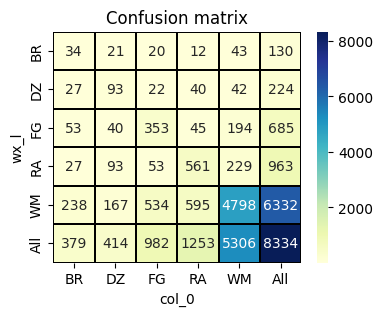

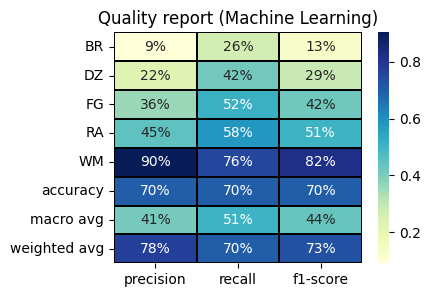

,feature,feature_per
50,dir2,7.0%
28,mod1,4.1%
30,mslp1,2.6%
4,wind_gust0,2.3%
73,T5002,2.3%
57,rh2,2.3%
84,lhflx3,2.0%
56,temp2,1.7%
13,swflx0,1.6%
60,lwflx2,1.5%


Round 1


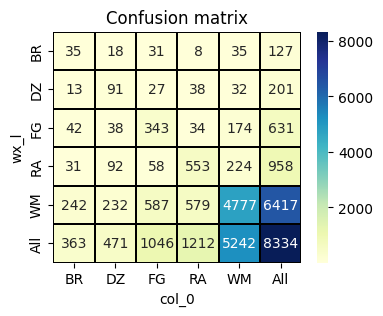

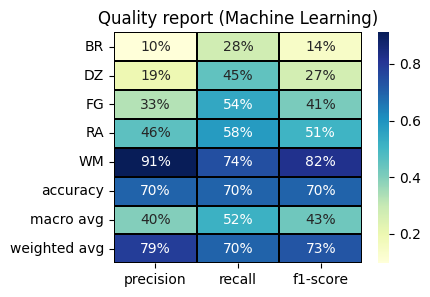

,feature,feature_per
53,mod2,5.5%
54,wind_gust2,4.7%
35,lwflx1,3.7%
6,temp0,3.3%
44,cfm1,2.5%
7,rh0,2.0%
29,wind_gust1,2.0%
75,dir3,1.6%
78,mod3,1.6%
100,hour,1.6%


Round 2


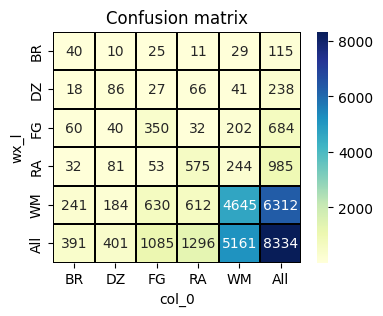

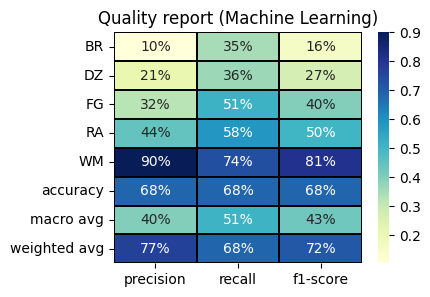

,feature,feature_per
43,cfl1,5.7%
53,mod2,4.3%
32,rh1,3.8%
78,mod3,3.3%
68,cfl2,3.0%
21,HGT5000,2.7%
33,visibility1,1.6%
100,hour,1.6%
75,dir3,1.5%
97,HGT8503,1.4%


Round 3


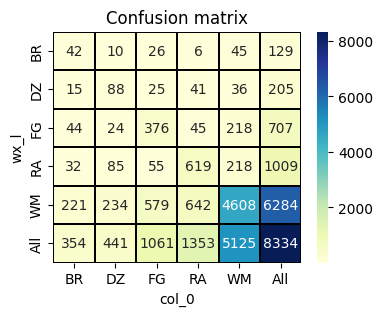

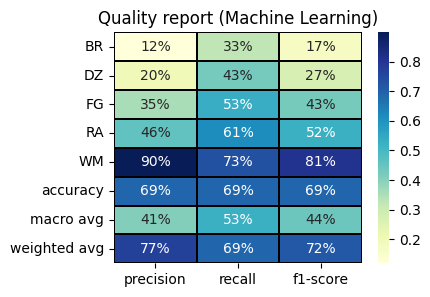

,feature,feature_per
95,cft3,3.9%
54,wind_gust2,3.9%
82,rh3,3.3%
30,mslp1,3.3%
28,mod1,2.6%
3,mod0,2.5%
32,rh1,2.4%
79,wind_gust3,2.0%
100,hour,1.9%
29,wind_gust1,1.9%


Round 4


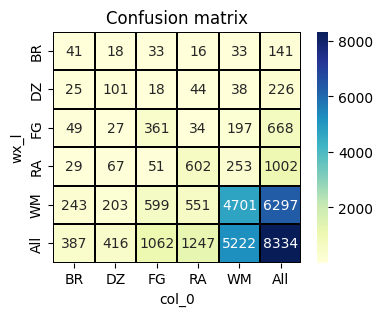

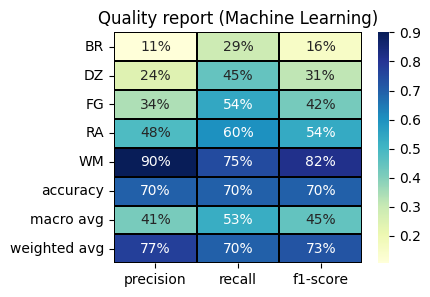

,feature,feature_per
47,HGT8501,5.7%
28,mod1,5.4%
7,rh0,4.2%
25,dir1,2.6%
10,lwflx0,2.0%
75,dir3,1.9%
68,cfl2,1.8%
74,T8502,1.6%
71,HGT5002,1.6%
57,rh2,1.5%


Execution time: 0.37 minutes


In [ ]:
#@title ML RandomForestClassifier. Samples 10. Heidke Skill score.

from sklearn.tree import ExtraTreeClassifier

start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.wx_l
X = df_all.iloc[:,1:]


# loop random
acc_ml = []
for t in range (0,5):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = ExtraTreeClassifier().fit(X_res,y_res)
  y_pred = ml_model.predict(X_test)
  acc_ml.append(round(accuracy_score(y_test, y_pred),2))
  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)

  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix")
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])




#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")





Round 0


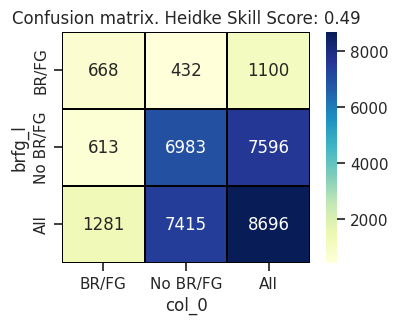

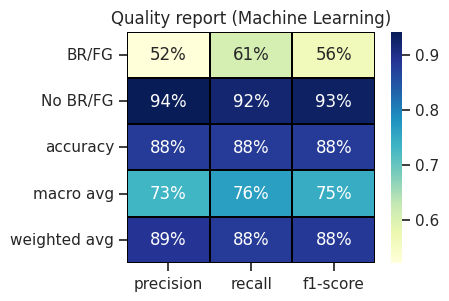

,feature,feature_per
102,dayofyear,4.7%
100,hour,3.5%
101,month,2.1%
7,rh0,1.7%
103,weekofyear,1.6%
50,dir2,1.6%
17,cfh0,1.6%
54,wind_gust2,1.6%
58,visibility2,1.5%
12,prec0,1.5%


Round 1


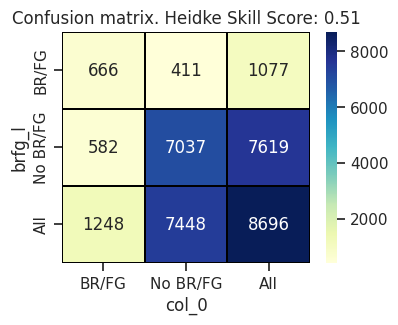

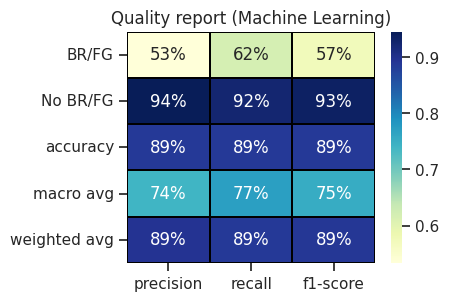

,feature,feature_per
102,dayofyear,4.6%
100,hour,3.3%
101,month,2.2%
62,prec2,2.1%
54,wind_gust2,1.8%
50,dir2,1.8%
37,prec1,1.7%
58,visibility2,1.5%
103,weekofyear,1.4%
12,prec0,1.4%


Round 2


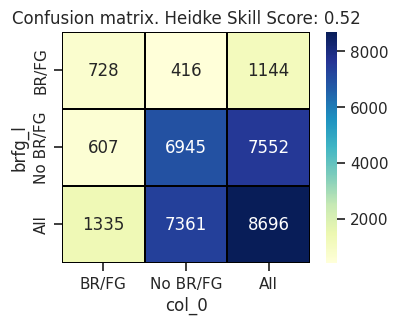

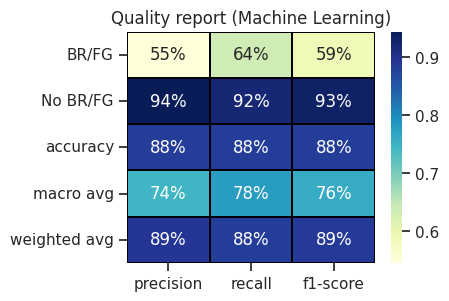

,feature,feature_per
102,dayofyear,4.7%
100,hour,3.2%
101,month,2.1%
50,dir2,2.1%
54,wind_gust2,1.8%
17,cfh0,1.6%
25,dir1,1.6%
103,weekofyear,1.5%
7,rh0,1.5%
62,prec2,1.4%


Round 3


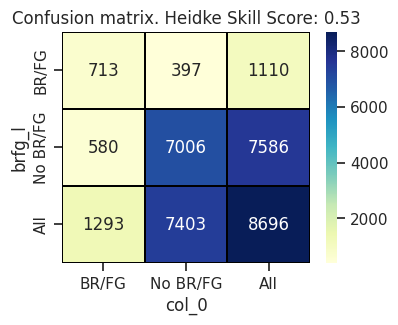

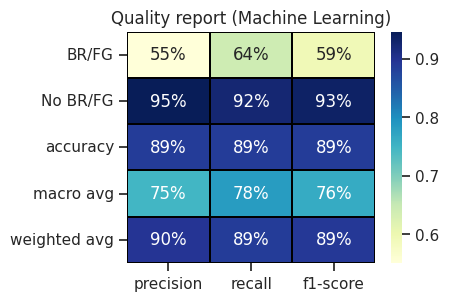

,feature,feature_per
102,dayofyear,4.3%
100,hour,3.5%
101,month,2.2%
103,weekofyear,1.8%
7,rh0,1.7%
62,prec2,1.7%
50,dir2,1.6%
17,cfh0,1.6%
37,prec1,1.6%
58,visibility2,1.5%


Round 4


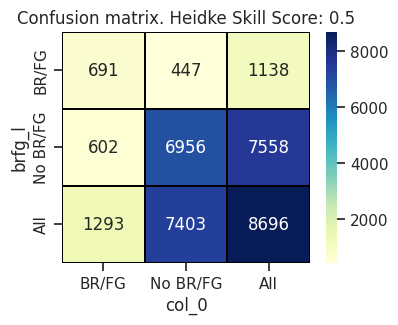

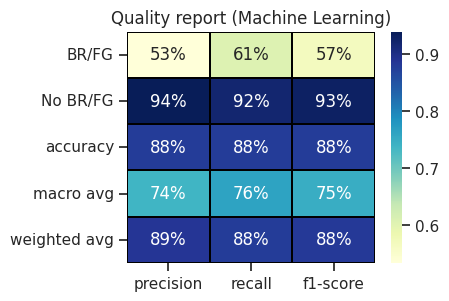

,feature,feature_per
102,dayofyear,4.4%
100,hour,3.5%
101,month,2.2%
103,weekofyear,1.9%
12,prec0,1.7%
7,rh0,1.7%
50,dir2,1.6%
87,prec3,1.5%
37,prec1,1.5%
32,rh1,1.4%


Round 5


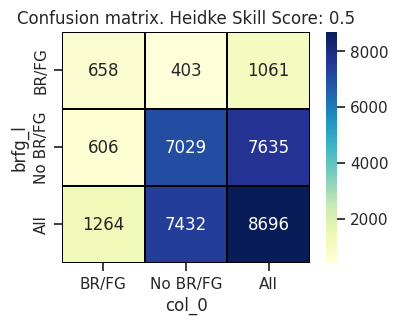

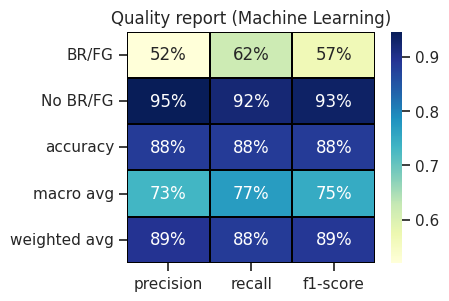

,feature,feature_per
102,dayofyear,4.8%
100,hour,3.4%
101,month,2.3%
103,weekofyear,1.8%
12,prec0,1.8%
37,prec1,1.8%
0,dir0,1.7%
32,rh1,1.6%
7,rh0,1.6%
54,wind_gust2,1.6%


Round 6


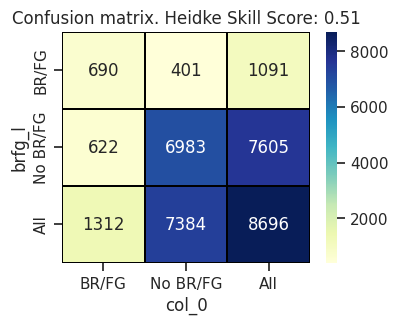

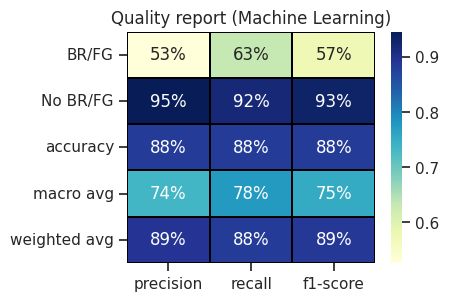

,feature,feature_per
102,dayofyear,4.6%
100,hour,3.4%
101,month,2.4%
17,cfh0,1.8%
103,weekofyear,1.7%
58,visibility2,1.6%
50,dir2,1.6%
54,wind_gust2,1.6%
7,rh0,1.5%
25,dir1,1.4%


Round 7


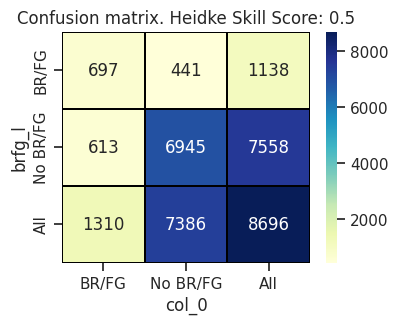

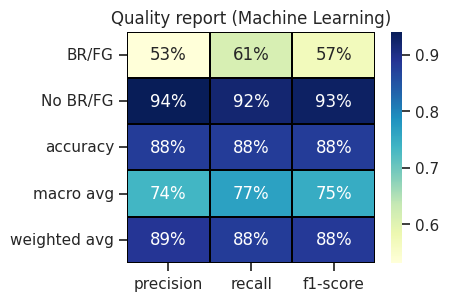

,feature,feature_per
102,dayofyear,4.7%
100,hour,3.2%
101,month,2.2%
54,wind_gust2,1.9%
12,prec0,1.7%
17,cfh0,1.7%
87,prec3,1.7%
50,dir2,1.6%
103,weekofyear,1.6%
0,dir0,1.5%


Round 8


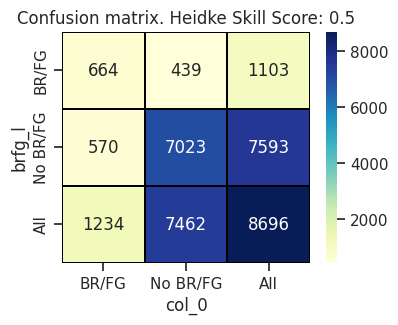

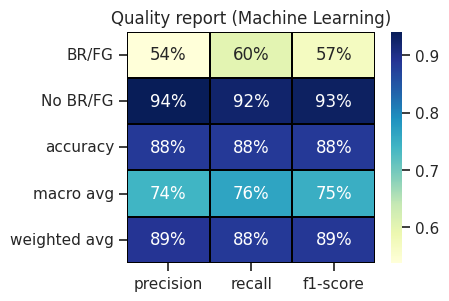

,feature,feature_per
102,dayofyear,4.8%
100,hour,3.4%
101,month,2.2%
54,wind_gust2,1.8%
103,weekofyear,1.6%
50,dir2,1.6%
58,visibility2,1.5%
0,dir0,1.5%
75,dir3,1.5%
25,dir1,1.4%


Round 9


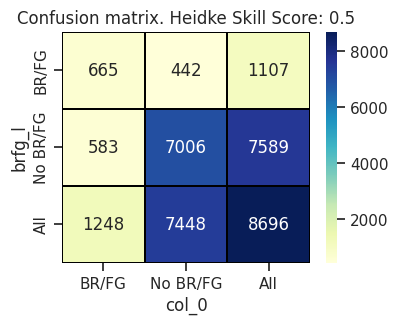

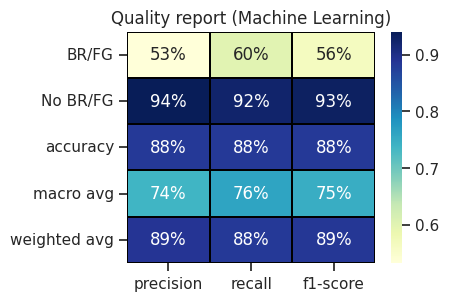

,feature,feature_per
102,dayofyear,4.7%
100,hour,3.0%
101,month,2.1%
103,weekofyear,1.8%
12,prec0,1.8%
54,wind_gust2,1.7%
50,dir2,1.7%
25,dir1,1.5%
14,shflx0,1.5%
32,rh1,1.5%



HSS stadistics
             HSS
count  10.000000
mean    0.504997
std     0.011159
min     0.491959
25%     0.498859
50%     0.500557
75%     0.507232
max     0.528682
Shapiro test normality
p value: 0.10582589358091354
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 2152.966852705807
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 2.05 minutes


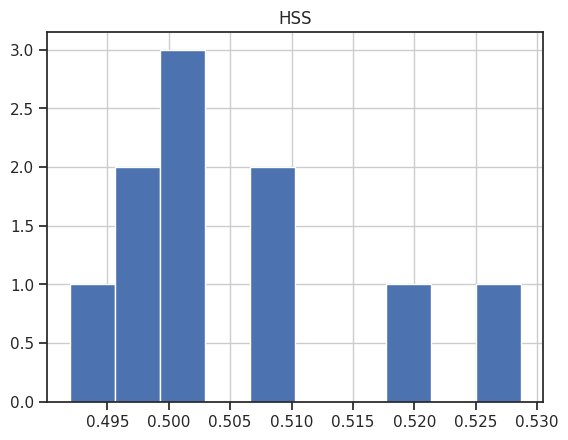

In [ ]:
#@title ML LGBMClassifier. Samples 10. Heidke Skill score

start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.brfg_l
X = df_all.iloc[:,1:]


# loop random
HSS = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  plt.figure(figsize=(4, 3))
  plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")